Fetching data... Iteration 1/5
Data fetched and updated successfully.
Fetching data... Iteration 2/5
Data fetched and updated successfully.
Fetching data... Iteration 3/5
Data fetched and updated successfully.
Fetching data... Iteration 4/5
Data fetched and updated successfully.
Fetching data... Iteration 5/5
Data fetched and updated successfully.
Data successfully saved to crypto_data.csv


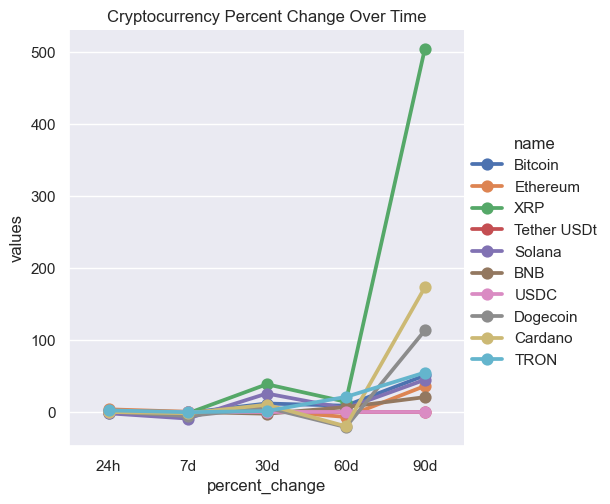

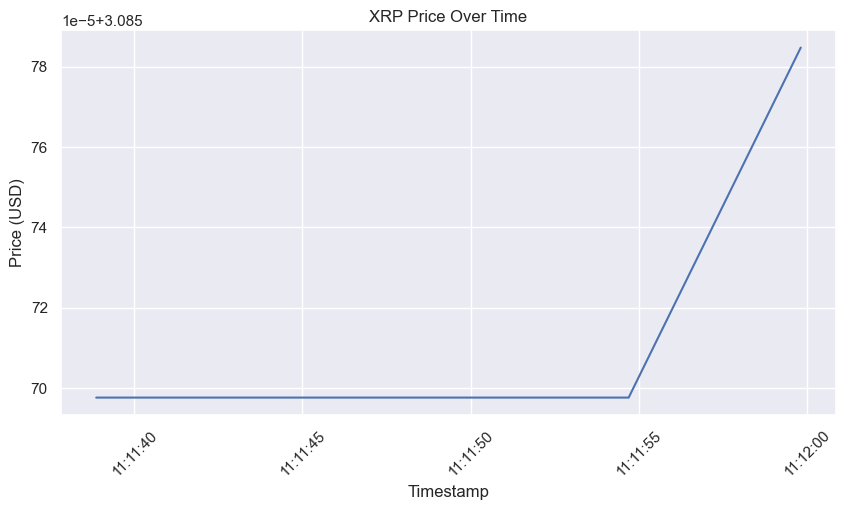

In [10]:
import json
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from requests import Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects

# 🔴 Enter your API key here (be careful not to share it!)
API_KEY = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

# API settings
URL = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
PARAMETERS = {
    'start': '1',
    'limit': '10',
    'convert': 'USD'
}
HEADERS = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': API_KEY,
}

# Create session
session = Session()
session.headers.update(HEADERS)

# Function to fetch data from API
def fetch_crypto_data():
    try:
        response = session.get(URL, params=PARAMETERS)
        response.raise_for_status()  # Raises error if request failed
        data = response.json()
        return data['data']
    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(f"Error fetching data: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

# Initialize DataFrame
df = pd.DataFrame()

# Function to fetch and append new data
def api_runner():
    global df
    new_data = fetch_crypto_data()
    if new_data:
        df_new = pd.json_normalize(new_data)
        df_new['timestamp'] = pd.Timestamp.now()

        # Append new data
        df = pd.concat([df, df_new], ignore_index=True)
        print("Data fetched and updated successfully.")

# Run API calls in a loop with controlled rate limits
for i in range(5):
    print(f"Fetching data... Iteration {i+1}/5")
    api_runner()
    time.sleep(5)  # Adjust sleep time to avoid hitting API rate limits

# Save data to a CSV file before visualization
df.to_csv("crypto_data.csv", index=False)
print("Data successfully saved to crypto_data.csv")

# Data processing for visualization
df_filtered = df.groupby('name', sort=False)[[
    'quote.USD.percent_change_24h',
    'quote.USD.percent_change_7d',
    'quote.USD.percent_change_30d',
    'quote.USD.percent_change_60d',
    'quote.USD.percent_change_90d'
]].mean()

df_stacked = df_filtered.stack().reset_index()
df_stacked.columns = ['name', 'percent_change', 'values']
df_stacked['percent_change'] = df_stacked['percent_change'].replace({
    'quote.USD.percent_change_24h': '24h',
    'quote.USD.percent_change_7d': '7d',
    'quote.USD.percent_change_30d': '30d',
    'quote.USD.percent_change_60d': '60d',
    'quote.USD.percent_change_90d': '90d'
})

# Plot percentage changes
sns.catplot(x='percent_change', y='values', hue='name', data=df_stacked, kind='point')
plt.title("Cryptocurrency Percent Change Over Time")
plt.show()

# Time-series visualization for XRP
df_xrp = df[df['name'] == 'XRP'][['timestamp', 'quote.USD.price']]

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.lineplot(x='timestamp', y='quote.USD.price', data=df_xrp)
plt.title("XRP Price Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.show()
